In [1]:
library(ggplot2)
library(stringr)
library(dplyr)
library(viridis)
library(ggbeeswarm)
library(ggpubr)
library(reshape2)
library(RColorBrewer)
library(shazam)
library(Seurat)
library(ggrastr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: viridisLite



To cite the SHazaM package in publications, please use:

  Gupta N, Vander Heiden J, Uduman M, Gadala-Maria D, Yaari G,
  Kleinstein S (2015). “Change-O: a toolkit for analyzing large-scale B
  cell immunoglobulin repertoire sequencing data.” _Bioinformatics_,
  1-3. doi:10.1093/bioinformatics/btv359
  <https://doi.org/10.1093/bioinformatics/btv359>.

To cite the selection analysis methods, please use:

  Yaari G, Uduman M, Kleinstein S (2012). “Quantifying selection in
  high-throughput Immunoglobulin sequencing data sets.” _Nucleic acids
  research_, *40*(17), e134. doi:10.1093/nar/gks457
  <https://doi.org/10.1093/nar/gks457>.

To cite the HH_S5F model and the targeting model generation methods,
please use:

  Yaari G, Vander Heiden J, Uduman M,

In [2]:
jz.save.umap.coord <- function(object) {
    # saves the UMAP embedding to the metadata 
    umapCoord <- as.data.frame(Embeddings(object = object[["umap"]]))
    object@meta.data$UMAP1 = umapCoord$umap_1
    object@meta.data$UMAP2 = umapCoord$umap_2
    return(object)
}

In [3]:
srat = readRDS('seurat_objects/03_cellphenotype_labeled_300.RDS')
# create a column to match bcr df 
srat$cell.id = str_split_i(srat$cell.id,'-',1)
srat

An object of class Seurat 
21228 features across 51751 samples within 1 assay 
Active assay: RNA (21228 features, 2000 variable features)
 3 layers present: data, counts, scale.data
 2 dimensional reductions calculated: pca, umap

In [4]:
bcr = read.csv('vdj_contigs/01_filtered_vdj_contig.csv')
summary(bcr$R1CONSCOUNT)
summary(bcr$N_count)
head(bcr,2)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
     5.0     17.0     39.0    361.1     91.0 125084.0 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.00000 0.00000 0.00000 0.07959 0.00000 5.00000 

,SEQUENCE_ID,SEQUENCE_INPUT,FUNCTIONAL,IN_FRAME,STOP,MUTATED_INVARIANT,INDELS,LOCUS,V_CALL,D_CALL,⋯,PVAL,SAMPLE,ID,SEQUENCE_TRIM,N_count,N_frac,barcode,sample,cell.id,chain
,<chr>,<chr>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<chr>,<chr>,<chr>,⋯,<dbl>,<chr>,<chr>,<chr>,<int>,<dbl>,<chr>,<chr>,<chr>,<chr>
1,CACAACATCCCACAGGCCCTTAATCGAG,NNNNNNNNNNNNNNNNNNNNNNNNNCGCTGTCTCTGGTTACTCCATCAGCAGTGGTTACTACTGGGGCTGGATCCGGCAGCCCCCAGGGAAGGGGCTGGAGTGGATTGGGAGTATCTATCATAGTGGGAGCACCTACTACAACCCGTCCCTCAAGAGTCGAGTCACCATATCAGTAGACACGTCCAAGAACCAGTTCTCCCTGAAGCTGAGCTCTGTGACCGCCGCAGACACGGCCGTGTATTACTGTGCGTCAACATGTAACGGGGAGCTATCCGAAAGTTGTTTCGACCCCTGGGGCCAGGGAACCCTGGTCACCGTCTCCTCAGNNNNNNNNNN,TRUE,TRUE,FALSE,NA,FALSE,IGH,IGHV4-38-2*01,"IGHD3-10*01,IGHD3-10*02,IGHD3-16*02",⋯,1.1102e-16,H1H,H1H_CACAACATCCCACAGGCCCTTAATCGAG,CGCTGTCTCTGGTTACTCCATCAGCAGTGGTTACTACTGGGGCTGGATCCGGCAGCCCCCAGGGAAGGGGCTGGAGTGGATTGGGAGTATCTATCATAGTGGGAGCACCTACTACAACCCGTCCCTCAAGAGTCGAGTCACCATATCAGTAGACACGTCCAAGAACCAGTTCTCCCTGAAGCTGAGCTCTGTGACCGCCGCAGACACGGCCGTGTATTACTGTGCGTCAACATGTAACGGGGAGCTATCCGAAAGTTGTTTCGACCCCTGGGGCCAGGGAACCCTGGTCACCGTCTCCTCAG,0,0,CACAACATCCCACAGG,H1,H1_CACAACATCCCACAGG,heavy
2,GGGTTATGTTCTCGCTGATGTAGCGACA,NNNNNNNNNNNNNNNNNNNNNNNNNGCTTCTGGATACACCTTCACCGGCTACTATATGCACTGGGTGCGACAGGCCCCTGGACAAGGGCTTGAGTGGATGGGATGGATCAACCCTAACAGTGGTGGCACAAACTATGCACAGAAGTTTCAGGGCAGGGTCACCATGACCAGGGACACGTCCATCAGCACAGCCTACATGGAGCTGAGCAGGCTGAGATCTGACGACACGGCCGTGTATTACTGTGCGAGAGTTACCACTATATTACGATTTTTGGAGTGGTCCTTGGGGTACTGGGGCCAGGGAACGCTGGTCACCGTCTCCTCAGNNNNNNNNNN,TRUE,TRUE,FALSE,NA,FALSE,IGH,IGHV1-2*02,IGHD3-3*01,⋯,1.1102e-16,H1H,H1H_GGGTTATGTTCTCGCTGATGTAGCGACA,GCTTCTGGATACACCTTCACCGGCTACTATATGCACTGGGTGCGACAGGCCCCTGGACAAGGGCTTGAGTGGATGGGATGGATCAACCCTAACAGTGGTGGCACAAACTATGCACAGAAGTTTCAGGGCAGGGTCACCATGACCAGGGACACGTCCATCAGCACAGCCTACATGGAGCTGAGCAGGCTGAGATCTGACGACACGGCCGTGTATTACTGTGCGAGAGTTACCACTATATTACGATTTTTGGAGTGGTCCTTGGGGTACTGGGGCCAGGGAACGCTGGTCACCGTCTCCTCAG,0,0,GGGTTATGTTCTCGCT,H1,H1_GGGTTATGTTCTCGCT,heavy


In [5]:
# split the bcr df into heavy and light 
heavy.bcr = bcr %>% filter(chain == 'heavy')
light.bcr = bcr %>% filter(chain == 'light')

In [6]:
# calculate shm frequency 
heavy.bcr.shm = heavy.bcr %>% filter(cell.id %in% srat$cell.id) %>% 
observedMutations(sequenceColumn = 'SEQUENCE_IMGT',germlineColumn = 'GERMLINE_IMGT', 
                       frequency = TRUE,combine=TRUE)
light.bcr.shm = light.bcr %>% filter(cell.id %in% srat$cell.id) %>% 
observedMutations(sequenceColumn = 'SEQUENCE_IMGT',germlineColumn = 'GERMLINE_IMGT', 
                       frequency = TRUE,combine=TRUE)

In [7]:
# match shm info to metadata 
srat$heavy.shm.freq = heavy.bcr.shm$mu_freq[match(srat$cell.id,heavy.bcr.shm$cell.id)]
srat$light.shm.freq = light.bcr.shm$mu_freq[match(srat$cell.id,light.bcr.shm$cell.id)]

In [8]:
# match bcr recovery information 
srat$heavy.recovery = ifelse(srat$cell.id %in% heavy.bcr$cell.id,1,0)
srat$light.recovery = ifelse(srat$cell.id %in% light.bcr$cell.id,1,0)
srat$Recovery = srat$heavy.recovery + srat$light.recovery * 2

In [9]:
# count umi info 
heavy.bcr.umi = heavy.bcr %>% count(cell.id,name = 'umi') 
light.bcr.umi = light.bcr %>% count(cell.id,name= 'umi')

In [10]:
# match umi info to metadata 
srat$heavy.umi = heavy.bcr.umi$umi[match(srat$cell.id,heavy.bcr.umi$cell.id)]
srat$light.umi = light.bcr.umi$umi[match(srat$cell.id,light.bcr.umi$cell.id)]

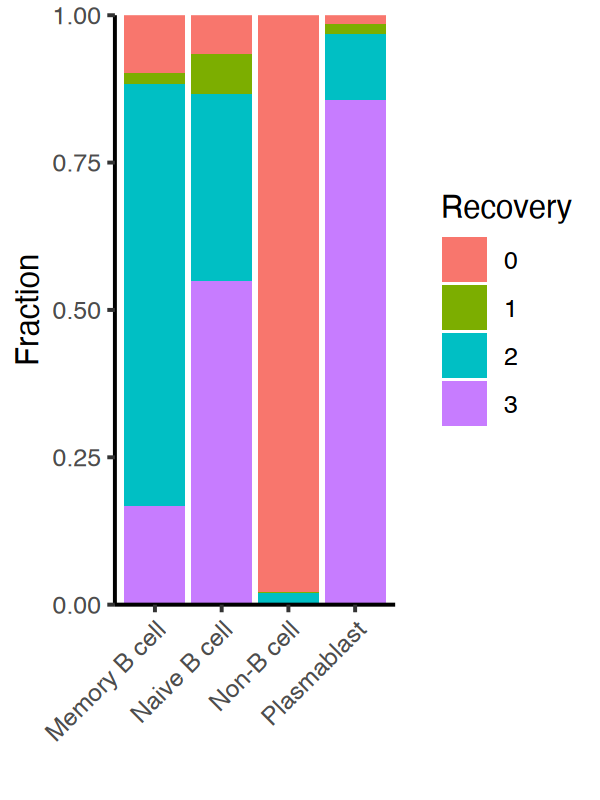

In [11]:
options(repr.plot.width=3,repr.plot.height=4,repr.plot.res=200)
metadata = srat@meta.data 
metadata %>% 
ggplot(aes(x=bcelltype,fill=factor(Recovery))) + theme_classic()+
geom_bar(position='fill') + 
labs(x='',y='Fraction',fill='Recovery') + 
scale_y_continuous(expand = c(0,0)) + 
theme(axis.text.x = element_text(angle=45, hjust=1))

In [ ]:
saveRDS(srat,'seurat_objects/04_10x_figure_ready_300.RDS')

In [ ]:
write.csv(srat@meta.data,'Zhang_10x3_metadata_recovery_labeled.csv')